# 1. Import and clean data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, save, load
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('TTT.xlsx')

In [4]:
dom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134316 entries, 0 to 134315
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   YEAR       134316 non-null  int64         
 1   FLT_MONTH  134316 non-null  int64         
 2   FLT_DATE   134316 non-null  datetime64[ns]
 3   week       134316 non-null  int64         
 4   SECTOR_2W  134316 non-null  object        
 5   Pax        134316 non-null  float64       
 6   seat       134316 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 7.2+ MB


In [5]:
dom

,YEAR,FLT_MONTH,FLT_DATE,week,SECTOR_2W,Pax,seat
0,2015,1,2015-01-01,1,DADBMV,134,136
1,2015,1,2015-01-01,1,DADHPH,203,272
2,2015,1,2015-01-01,1,DADPXU,123,136
3,2015,1,2015-01-01,1,DADVCA,334,360
4,2015,1,2015-01-01,1,DADVII,118,136
...,...,...,...,...,...,...,...
134311,2023,3,2023-03-27,13,SGNVDH,251,368
134312,2023,3,2023-03-27,13,SGNVII,753,1180
134313,2023,3,2023-03-27,13,SGNHPH,"1,018",1326
134314,2023,3,2023-03-27,13,SGNHUI,"1,183",1586


In [6]:
dom.set_index('FLT_DATE', inplace = True)

In [7]:
# df for model building:
df = dom[['SECTOR_2W','Pax','seat']].groupby('SECTOR_2W').resample('MS').sum()

In [8]:
df.reset_index(inplace = True)
df.rename(columns = {'SECTOR_2W':'ID','FLT_DATE':'ds','Pax':'y'}, inplace = True)

In [9]:
route_type = pd.read_excel('route type.xlsx')

In [10]:
route_type

,SECTOR_2W,sktime,kmeans,hierarchical,type
0,CXRTHD,other,Lunar,other,other
1,DADBMV,other,Summer,Summer,lunar summer
2,DADCXR,other,Lunar,other,summer
3,DADDLI,Lunar,Lunar,Lunar,other
4,DADHPH,Summer,Summer,Summer,summer
...,...,...,...,...,...
64,VCATHD,NaN,NaN,NaN,other
65,VCAVII,NaN,NaN,NaN,other
66,VIICXR,NaN,NaN,NaN,other
67,VIIDLI,NaN,NaN,NaN,other


In [11]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

# 2. Build model

## 2.1. Routes with only route peaks

In [12]:
route = df[df['ID']=='SGNDAD'][['ds','y','seat']]

In [13]:
route

,ds,y,seat
4034,2015-01-01,"186,833",220911
4035,2015-02-01,"205,683",275639
4036,2015-03-01,"219,481",256840
4037,2015-04-01,"213,239",264297
4038,2015-05-01,"226,622",277880
...,...,...,...
4128,2022-11-01,"227,670",265582
4129,2022-12-01,"260,109",296940
4130,2023-01-01,"307,459",365395
4131,2023-02-01,"253,585",286141


In [14]:
train = route[route['ds'] < '2022-07-01'].copy()
val = route[(route['ds'] >= '2022-07-01')&(route['ds'] < '2023-01-01')].copy()
test = route[route['ds'] >= '2023-01-01'].copy()

In [15]:
holidays = pd.read_excel('holidays.xlsx')
holidays = holidays.rename(columns={'holiday': 'event'})
# holidays = holidays[~holidays['event'].isin(['Lunar','Labor'])]

In [16]:
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [17]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,10),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 10),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'n_lags':trial.suggest_int('n_lags',1,12*2),
        'ar_reg':trial.suggest_float('ar_reg',0,10),
        #'newer_samples_weight':trial.suggest_float('newer_samples_weight',0,10),
        'learning_rate':trial.suggest_float('learning_rate',0.001,5),
        'num_hidden_layers':trial.suggest_int('num_hidden_layers',0,3)
    }
    lagged_regressor_params = {'regularization':trial.suggest_float('regularization',0,1)}
    
    # Create the model
    optuna_model = NeuralProphet(**params,
                                 changepoints = changepoints,
                                 daily_seasonality = False,
                                 weekly_seasonality= False,
                                 n_forecasts = 12)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')  
    optuna_model.add_events(events = ['Summer','Labor','Lunar'], mode='multiplicative')
    optuna_model.add_lagged_regressor('seat', **lagged_regressor_params)
    
    # create the data df with events
    train_df = optuna_model.create_df_with_events(train, train_holidays)
    val_df = optuna_model.create_df_with_events(val, val_holidays)
    
    # Fit the model
    metrics = optuna_model.fit(train_df, freq="MS")

    # Make predictions
    future_df = optuna_model.make_future_dataframe(train_df, events_df=holidays)
    optuna_forecast = optuna_model.predict(df=future_df)
    latest = optuna_model.get_latest_forecast(optuna_forecast)

    # Evaluate prediction
    result = val_df.merge(latest,how = 'left', on = 'ds')
    result.set_index('ds', inplace = True)
    rmse = np.sqrt(mean_squared_error(result['y_x'], result['origin-0'])).round(0)
    return rmse

In [18]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-04-06 17:03:56,197] A new study created in memory with name: no-name-5a71d099-6668-4afc-9849-426a5466260b


In [19]:
# study.optimize(objective, n_trials=100)

In [20]:
# params =  study.best_trial.params
params = {'trend_reg': 7.413180556827008, 'seasonality_reg': 9.479228248187582, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'n_lags': 16, 'ar_reg': 0.36009554401310995, 'learning_rate': 1.8978281383344067, 'num_hidden_layers': 3, 'regularization': 0.31020051035009005}

In [21]:
regularization = params.pop('regularization')

In [22]:
set_random_seed(99)

In [23]:
m = NeuralProphet(**params,
                  changepoints = changepoints,
                  daily_seasonality = False,
                  weekly_seasonality = False,
                  n_forecasts = 12)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4'], mode='multiplicative')
m.add_events(events = ['Summer','Labor','Lunar'], mode='multiplicative')
m.add_lagged_regressor('seat', regularization = regularization)

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (16)
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.625% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 688


Training: 0it [00:00, ?it/s]

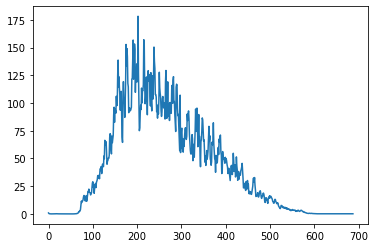

In [24]:
metrics = m.fit(train_val_df,
                freq="MS",
                progress="plot")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


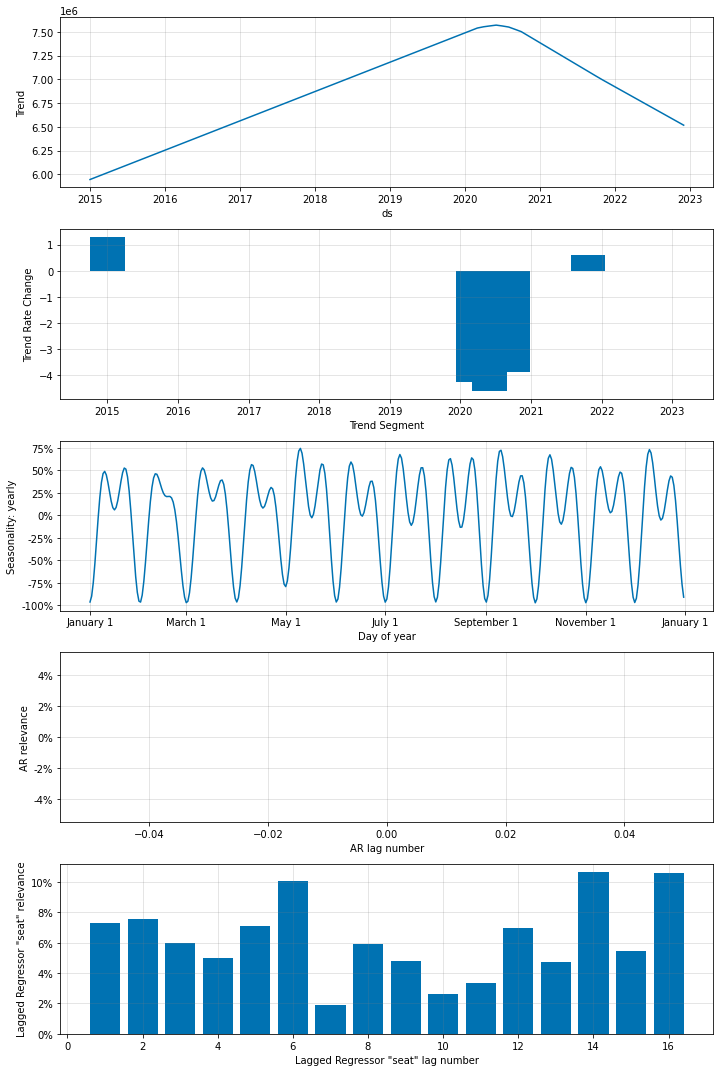

In [25]:
fig_param = m.plot_parameters()

In [26]:
future = m.make_future_dataframe(train_val_df, n_historic_predictions=True, events_df=holidays)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.625% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [27]:
future[(future['ds']>='2023-01-01')&(future['ds']<'2023-02-01')]

,ds,y,seat,covid_1,covid_2,covid_3,covid_4,Summer,Labor,Lunar
96,2023-01-01,NaN,None,0,0,0,0,0,0,0


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.741% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.741% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS


Predicting: 5it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


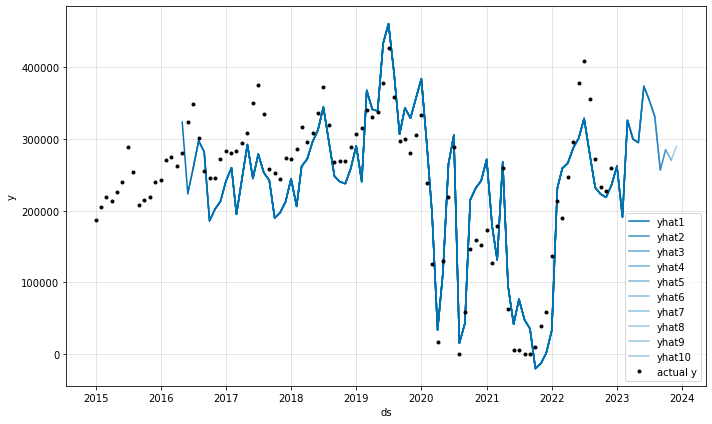

In [28]:
forecast = m.predict(future, decompose = False)
fig = m.plot(forecast)

In [29]:
latest = m.get_latest_forecast(forecast,include_history_data=True)

In [30]:
result = test_df.merge(latest,how = 'left', on = ['ds'])

In [31]:
result.to_excel('forecast.xlsx')

In [32]:
save(m,'SGNDAD.np')